<a href="https://colab.research.google.com/github/souken-b/calc_OWC/blob/main/calc_pulsating_pres_with_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [475]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [476]:
global p_air, dens_air, h_ratio
period = 0.066 # 周期
n = 1000 # 周期あたりの分割数
total_time = period
#############堀内論文##############
n_diam = 0.008123 # オリフィス直径(m)
D0 = 0.0254 # 円管の直径(m)
global Ap, Vm, R, L
A = 5.1823028331816915 * 1e-05 # オリフィスの断面積(m2)
A0 = np.pi * ((D0 / 2) ** 2) # 円管の断面積(m2)
Ap = 0.0019540819402 # ピストン部の断面積
Vm = 0.000120931849 # t=0での空気室容積(m3)
R = 0.0271
L = 0.1583
d_ratio = n_diam / D0 # 絞り直径比
n_ratio = d_ratio ** 2 # 絞り面積比
#################################

#############中型模型##############
# n_diam = 0.035 # オリフィス直径(m)
# D0 = 0.5 # 円管の直径(m)
# A = 0.00096211275 # オリフィスの断面積(m2)
# A0 = 0.19242255 # 円管の断面積(m2)
# d_ratio = n_diam / D0 # 絞り直径比
#################################
h_ratio = 1.4 # 比熱比
p_air = 101325 # 大気圧(pa)
dens_air = 1.225 # 空気の密度(kg/m3)

In [477]:
Zh = 0.02750688
Zh0 = 0.625
phase_diff = 0

In [478]:
def calc_density(p):
  dens = dens_air * ((p / p_air) ** (1/h_ratio))
  return dens

In [479]:
def incomp_condensation_coef(d_ratio)->'非圧縮性の縮流係数':
  # 流量係数
  flow_coef = 0.598 - 0.003 * (d_ratio ** 2) + 0.404 * (d_ratio ** 4)
  return (flow_coef / ((1 + (d_ratio ** 4) * (flow_coef ** 2)) ** (1/2)))

In [480]:
def incomp_force_coef(c_ci)->'非圧縮性力欠損係数':
  return ((1 / c_ci) - (1 / (2 * (c_ci ** 2))))

In [481]:
def comp_condensation_coef(f_ci_c, p_up, p_down)->'圧縮性の縮流係数':
  p_ratio = p_up / p_down
  h_ratio_rev = 1/ h_ratio
  return ((1 / (2 * f_ci_c)) * (p_ratio ** h_ratio_rev) * (1 - (1 - ((2 * f_ci_c * (1 - h_ratio_rev)) * (1 - (1 / p_ratio)) / (1- (p_ratio) ** (h_ratio_rev - 1))))  ** (1/2)))

In [482]:
def calc_forward_p_delta(p_prev, p_current, f_ci, h, dens_prev, dens_current, V0, dV0dt, dV02dt2, A, A0)->'押出過程での圧力勾配を計算':
  ########## i番目の流量を求める #############
  if (p_prev > p_air):
    # 押出過程
    c_c_prev = comp_condensation_coef(f_ci, p_prev, p_air)
    flow_prev = forward_flow(c_c_prev, A, p_prev, dens_prev)
  else:
    # 吸込過程
    c_c_prev = comp_condensation_coef(f_ci, p_air, p_prev)
    flow_prev = (-1) * back_flow(c_c_prev, A, p_prev)
  ######################################
  
  ########## i+1番目の流量を求める###########
  c_c_current = comp_condensation_coef(f_ci, p_current, p_air)
  flow_current = forward_flow(c_c_current, A, p_current, dens_current)
  ######################################

  p_delta = forward_delta_p(dens_current, V0, dV0dt, dV02dt2, flow_prev, flow_current, h, A0)
  return p_delta


In [483]:
def calc_back_p_delta(p_prev, p_current, f_ci, h, dens_prev, dens_current, V0, dV0dt, dV02dt2, A, A0)->'吸込過程での圧力勾配を計算':
  ########## i番目の流量を求める #############
  if (p_prev > p_air):
    # 押出過程
    c_c_prev = comp_condensation_coef(f_ci, p_prev, p_air)
    flow_prev = forward_flow(c_c_prev, A, p_prev, dens_prev)
  else:
    # 吸込過程
    c_c_prev = comp_condensation_coef(f_ci, p_air, p_prev)
    flow_prev = (-1) * back_flow(c_c_prev, A, p_prev)
  ######################################
  
  ########## i+1番目の流量を求める###########
  c_c_current = comp_condensation_coef(f_ci, p_air, p_current)
  flow_current = (-1) * back_flow(c_c_current, A, p_current)
  ######################################

  p_delta = back_delta_p(dens_current, V0, dV0dt, dV02dt2, flow_prev, flow_current, h, A0)
  return p_delta

In [484]:
def runge_kutta(h: '時間分割', t, total_split, c_freq, phase_diff, p, p_delta, V0, dV0dt, dV02dt2, d_ratio, A0, A, Zh, Zh0)->'Runge-Kutta法を用いた圧力の計算, 圧力勾配, 空気室内容積変位の計算':
  # 非圧縮性の縮流係数
  c_ci = incomp_condensation_coef(d_ratio)
  # 非圧縮性の力欠損係数
  f_i = incomp_force_coef(c_ci)

  # 方程式を解くための反復計算
  for i in range(total_split -1):
    #######runge-kutta法により圧力を計算#######
    arg_list = [c_freq, d_ratio, V0[i], dV0dt[i], A, f_i] # dpdtの引数
    k_1 = h * calc_dpdt(p[i], t[i], *arg_list)
    k_2 = h * calc_dpdt(p[i] + k_1 / 2 , t[i] + h/2, *arg_list)
    k_3 = h * calc_dpdt(p[i] + k_2 / 2 , t[i] + h/2, *arg_list)
    k_4 = h * calc_dpdt(p[i] + k_3, t[i] + h, *arg_list)
    p[i+1] = p[i] + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
    #####################################

    ###########空気室内容積を計算############
    ###############中型模型################
    # V0[i+1] = (Zh0 + Zh * np.cos(c_freq * t[i] + phase_diff)) * A0
    # dV0dt[i+1] = ((-1) * c_freq * Zh * np.sin(c_freq * t[i] + phase_diff)) * A0
    # dV02dt2[i+1] = ((-1) * ((c_freq) ** 2) * Zh * np.cos(c_freq * t[i] + phase_diff)) * A0
    #####################################
    ###############堀内実験################
    V0[i+1] = Vm - Ap * ((R * np.cos(c_freq * t[i+1]+phase_diff)) + (((R**2) / (4 * L)) * np.cos(2 * c_freq * t[i+1] + phase_diff)))
    dV0dt[i+1] = Ap * c_freq * ((R * np.sin(c_freq * t[i+1] + phase_diff)) + (((R ** 2) / (2 * L)) * np.sin(2 * c_freq * t[i+1] + phase_diff)))
    dV02dt2[i+1] = Ap * (c_freq ** 2) * ((R * np.cos(c_freq * t[i+1] + phase_diff)) + (((R ** 2) / L)) * np.cos(2 * c_freq * t[i+1] + phase_diff))
    #####################################
    #####################################

    ##########圧力勾配を計算################
    dens_prev = calc_density(p[i])
    dens_current = calc_density(p[i+1])

    arg_list_2 = [p[i], p[i+1], f_i, h, dens_prev, dens_current, V0[i+1], dV0dt[i+1], dV02dt2[i+1], A, A0] # calc_p_deltaの引数
    p_delta[i+1] = calc_forward_p_delta(*arg_list_2) if (p[i+1] > p_air) else calc_back_p_delta(*arg_list_2)
    #####################################

    # pがnanの場合はbreakさせる
    if (np.isnan(p[i+1])):
      print('p is not nan')
      break

  return t, p, V0, p_delta

In [485]:
def call_calc_state(n, period, total_time, phase_diff, d_ratio, A0, A, Zh, Zh0)->'圧力, 圧力勾配, 空気室内容積変位計算の呼び出し':
  h = period / n # 分割時間
  t = np.arange(0, total_time, h)
  c_freq = 2 * np.pi / period # 円振動数
  total_split = len(t)
  p, V0, dV0dt, dV02dt2, p_delta = [np.empty(total_split) for i in range(5)]
  p[0], p_delta[0] = p_air + 5, 10
  # V0[0], dV0dt[0], dV02dt2[0] = (Zh0 + Zh * np.cos(phase_diff)) * A0, ((-1) * c_freq * Zh * np.sin(phase_diff)) * A0, ((-1) * ((c_freq) ** 2) * Zh * np.cos(phase_diff)) * A0
  V0[0], dV0dt[0], dV02dt2[0] = Vm - Ap * ((R * np.cos(phase_diff)) + (((R**2) / (4 * L)) * np.cos(phase_diff))), Ap * c_freq * ((R * np.sin(phase_diff)) + (((R ** 2) / (2 * L)) * np.sin(phase_diff))), Ap * (c_freq ** 2) * ((R * np.cos(phase_diff)) + (((R ** 2) / L)) * np.cos(phase_diff))

  t, p, V0, p_delta = runge_kutta(h, t, total_split, c_freq, phase_diff, p, p_delta, V0, dV0dt, dV02dt2, d_ratio, A0, A, Zh, Zh0)
  
  return t, p, V0, p_delta

In [486]:
def forward_flow(c_c, A, p_up, dens_up)->'押出流量':
  h_ratio_rev = 1 / h_ratio
  return  (dens_up / dens_air) * (c_c * A  * ((p_up / p_air) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_up / dens_up) * (1 - (p_up / p_air) ** (h_ratio_rev - 1))) ** (1 / 2)))

In [487]:
def back_flow(c_c, A, p_down)->'吸込流量':
  h_ratio_rev = 1 / h_ratio
  return  c_c * A  * ((p_air / p_down) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_air / dens_air) * (1 - (p_air / p_down) ** (h_ratio_rev - 1))) ** (1 / 2))

In [488]:
def forward_delta_p(dens, V0, dV0dt, dV02dt2, flow_prev, flow_current, delta_t, A0)->'押出圧力補正':
  flow_diff = (flow_current - flow_prev) / delta_t # 流量変動
  # delta_p = (-1) * ((dens ** 2) / (A0 ** 2)) * (dV02dt2 + (dens_air / dens) * flow_diff + (1 / 2) * (dV0dt + (1 / dens) * (dens_air * flow_current)) * dV0dt) # 中型模型
  delta_p = (-1) * ((dens ** 2) / (Ap ** 2)) * (V0 * (dV02dt2 + (dens_air / dens) * flow_diff) + (1 / 2) * (dV0dt + (1 / dens) * (dens_air * flow_current)) * dV0dt) # 堀内論文
  return delta_p

In [489]:
def back_delta_p(dens, V0, dV0dt, dV02dt2, flow_prev, flow_current, delta_t, A0)->'吸込圧力補正':
  flow_diff = (flow_current - flow_prev) / delta_t # 流量変動
  # delta_p = (-1) * ((dens ** 2) / (A0 ** 2)) * (dV02dt2 + ((7/2) * ((dens_air / dens) ** h_ratio) * (flow_diff)) - ((5/2) * (dens_air / dens) * (flow_diff)) + (1/2) * (dV0dt + ((1 / 2) * ((7 * ((dens_air / dens) ** (h_ratio + 1))) - 5) * ( 1 / dens) * (dens_air * flow_current))) * dV0dt) # 中型模型
  delta_p = (-1) * ((dens ** 2) / (Ap ** 2)) * (V0 * (dV02dt2 + ((7/2) * ((dens_air / dens) ** h_ratio) * (flow_diff)) - ((5/2) * (dens_air / dens) * (flow_diff))) + (1/2) * (dV0dt + ((1 / 2) * ((7 * ((dens_air / dens) ** (h_ratio + 1))) - 5) * ( 1 / dens) * (dens_air * flow_current))) * dV0dt) # 堀内実験
  return delta_p

In [490]:
def calc_dpdt(p, t, c_freq, d_ratio, V0, dV0dt, A, f_ci)->'圧力変動':
  dens = calc_density(p)
  if (p > p_air):
    # 押出過程
    c_c = comp_condensation_coef(f_ci, p, p_air)
    flow = forward_flow(c_c, A, p, dens)
    dpdt = (-7/5) * p * ((dV0dt / V0) + ((dens_air / dens) * (flow / V0)))
  else:
    # 吸込過程
    c_c = comp_condensation_coef(f_ci, p_air, p)
    flow = back_flow(c_c, A, p)
    dpdt = (-7/5) * p * ((dV0dt / V0) + (((dens_air / dens) ** h_ratio) * (((-1) * flow) / V0)))
  return dpdt

In [491]:
result = call_calc_state(n, period, total_time, phase_diff, d_ratio, A0, A, Zh, Zh0)
t_list, p_list, v0_list, p_delta_list = result

In [492]:
p_air_list = [p_air] * len(p_list)
p_list_diff = p_list - p_air_list

In [493]:
p_list_correct = p_list + p_delta_list

In [494]:
def calc_flow(f_ci, p_list):
  flow_list = []
  for p in p_list:
    dens = calc_density(p)
    if (p > p_air):
      c_c = comp_condensation_coef(f_ci, p, p_air)
      flow = forward_flow(c_c, A, p, dens)
    else:
      c_c = comp_condensation_coef(f_ci, p_air, p)
      flow = (-1) * back_flow(c_c, A, p)
    flow_list.append(flow)
  return flow_list


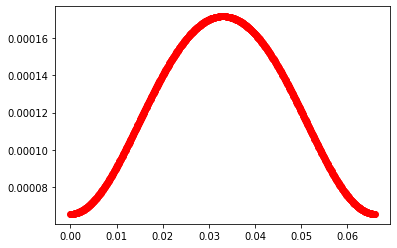

In [495]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, v0_list, c='red')
plt.show()

In [496]:
# 非圧縮性の縮流係数
c_ci = incomp_condensation_coef(d_ratio)
# 非圧縮性の力欠損係数
f_ci = incomp_force_coef(c_ci)
flow = calc_flow(f_ci, p_list)
flow_correct = calc_flow(f_ci, p_list_correct)

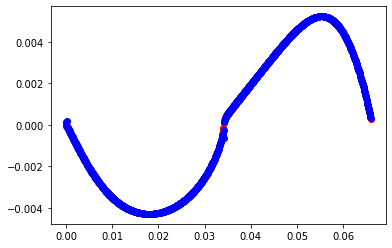

In [497]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, flow, c='red')
ax.scatter(t_list, flow_correct, c='blue')
plt.show()

In [498]:
flow = np.array(flow)
flow_correct = np.array(flow_correct)

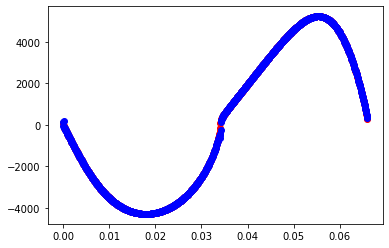

In [499]:
flow_cc = flow * (10 ** 6)
flow_correct_cc = flow_correct * (10 ** 6)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, flow_cc, c='red')
ax.scatter(t_list, flow_correct_cc, c='blue')
plt.show()

In [500]:
p_list_diff = p_list - p_air_list
p_list_correct_diff = p_list_correct - p_air_list
p_list_diff_mmh2o = p_list * (1 / 9.8)
p_list_correct_diff_mmh2o = p_list_correct * (1 / 9.8)

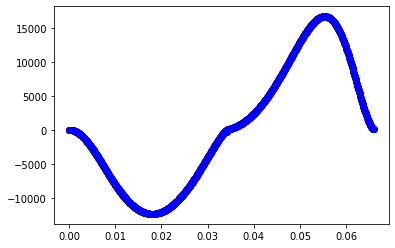

In [501]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, p_list_diff, c='red')
ax.scatter(t_list, p_list_correct_diff, c='blue')
plt.show()

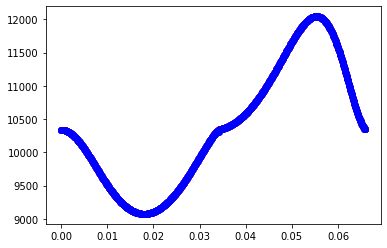

In [502]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, p_list_diff_mmh2o, c='red')
ax.scatter(t_list, p_list_correct_diff_mmh2o, c='blue')
plt.show()

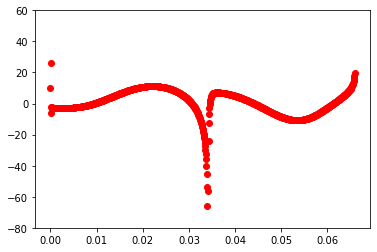

In [503]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, p_delta_list, c='red')
plt.ylim(-80, 60)
plt.show()

In [504]:
# from google.colab import drive
# drive.mount('/content/drive')

In [505]:
# import pandas as pd
# exp_data = pd.read_csv('drive/My Drive/a375_3_exp.csv', header=None)

In [506]:
# exp_time = exp_data[0]
# exp_pres = exp_data[1]

In [507]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.scatter(t_list, p_list_diff, c='red')
# ax.scatter(t_list, p_list_diff_correct, c='blue')
# ax.scatter(exp_time, exp_pres, c='orange')
# plt.show()